In [1]:
# ⚙️ Device & AMP
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_mixed_precision = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 7
print(f"🚀 Using device: {device}")
print("⚡ Mixed precision ON" if use_mixed_precision else "🔄 Full precision")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"🔥 GPU Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")
    
try:
    scaler = torch.amp.GradScaler('cuda') if use_mixed_precision else None
except Exception:
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

🚀 Using device: cuda
⚡ Mixed precision ON
🔥 GPU Memory: 15.8 GB


In [7]:
# ⚙️ Universal multi-organ scanner for /2d_images
from pathlib import Path
import os, csv, random, re
from PIL import Image

BASE = Path("/kaggle/input/msd-2d-images/2d_images")  # or your local path
OUT  = Path("./msd2d_out"); OUT.mkdir(parents=True, exist_ok=True)
INDEX_CSV = OUT / "index.csv"

EXT = ".png"
MASK_SUFFIX = "_mask"
GLOBAL_MAX, MAX_FOLDERS, MAX_FILES_PER_DIR = 200000, 50, 20000
PAD, MIN_AREA = 6, 16
rng = random.Random(123)

# --- identify organ type from filename or folder ---
def infer_organ_type(p: str):
    p = p.lower()
    if re.search(r"brain|brats|head", p):       return "brain"
    if re.search(r"lung|chest|ct_lung", p):     return "lung"
    if re.search(r"liver", p):                  return "liver"
    if re.search(r"kidney|renal", p):           return "kidney"
    if re.search(r"spleen", p):                 return "spleen"
    if re.search(r"colon", p):                  return "colon"
    if re.search(r"pancreas", p):               return "pancreas"
    if re.search(r"heart|cardiac", p):          return "heart"
    if re.search(r"hippocampus|hipp", p):       return "hippocampus"
    if re.search(r"prostate", p):               return "prostate"
    return "other"

def mask_path_for(img_path: Path) -> Path:
    return img_path.with_name(img_path.stem + MASK_SUFFIX + img_path.suffix)

def bbox_from_mask_fast(mask_path: Path):
    with Image.open(mask_path).convert("L") as im:
        box = im.getbbox()
        W, H = im.size
        if box is None:
            return None, (W, H)
        x1, y1, x2, y2 = box
        x1 = max(0, x1 - PAD); y1 = max(0, y1 - PAD)
        x2 = min(W, x2 + PAD); y2 = min(H, y2 + PAD)
        if (x2 - x1) * (y2 - y1) < MIN_AREA:
            return None, (W, H)
        return [x1, y1, x2, y2], (W, H)

rows = []
folders = sorted([d for d in BASE.iterdir() if d.is_dir()])[:MAX_FOLDERS]
print("Scanning folders:", [f.name for f in folders])
target_per_folder = GLOBAL_MAX // max(1, len(folders))

for d in folders:
    kept = 0
    folder_limit = min(MAX_FILES_PER_DIR, target_per_folder)
    files = [Path(d.path if isinstance(d, os.DirEntry) else d) / e.name
             for e in os.scandir(d) if e.is_file() and e.name.endswith(EXT)
             and not e.name.endswith(MASK_SUFFIX + EXT)]
    rng.shuffle(files)

    for img in files:
        if kept >= folder_limit or len(rows) >= GLOBAL_MAX:
            break
        mp = mask_path_for(img)
        if not mp.exists(): continue
        box, (W, H) = bbox_from_mask_fast(mp)
        if box is None: continue
        organ = infer_organ_type(str(img))
        rows.append([str(img), str(mp), organ, W, H, *box, -1.0])
        kept += 1

    print(f"{d.name:20s} | kept {kept:5d} | total so far {len(rows):7d}")

with open(INDEX_CSV, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["image_path","mask_path","organ","W","H","x1","y1","x2","y2","fg_frac"])
    w.writerows(rows)

print(f"✅ Wrote {len(rows)} items to {INDEX_CSV}")
print("Organs found:", {o for _,_,o,*_ in rows})


Scanning folders: ['Task01_BrainTumour', 'Task02_Heart', 'Task04_Hippocampus', 'Task05_Prostate', 'Task06_Lung', 'Task07_Pancreas', 'Task08_HepaticVessel', 'Task09_Spleen', 'Task10_Colon']


KeyboardInterrupt: 

In [2]:
# 📚 Dataset: expects msd2d_out/index.csv with columns: image_path, mask_path
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import torch

INDEX_CSV = Path("/kaggle/input/55k-index/index.csv")
assert INDEX_CSV.exists(), f"Missing {INDEX_CSV}; update path if needed."

df = pd.read_csv(INDEX_CSV)
assert {"image_path","mask_path"}.issubset(df.columns), "index.csv must have 'image_path' and 'mask_path' columns"

n_before = len(df)
df = df.dropna(subset=["image_path","mask_path"]).copy()
df["image_path"] = df["image_path"].astype(str)
df["mask_path"]  = df["mask_path"].astype(str)
print(f"📊 Loaded {n_before} rows; {len(df)} after dropna.")

def _exists(p):
    try: return Path(p).exists()
    except Exception: return False

ok_img = df["image_path"].map(_exists)
ok_msk = df["mask_path"].map(_exists)
df = df[ok_img & ok_msk].reset_index(drop=True)
print(f"✅ Validated {len(df)} rows with existing image & mask files.")

class MedicalDataset(torch.utils.data.Dataset):
    def __init__(self, frame, resize_to=(320,320), training=True):
        self.df = frame.reset_index(drop=True)
        self.resize_to = resize_to
        self.training = training

    def __len__(self): return len(self.df)

    def _read_img(self, p):
        p = Path(p)
        if p.suffix.lower() in [".npy", ".npz"]:
            arr = np.load(p) if p.suffix.lower()==".npy" else np.load(p)["arr_0"]
            if arr.ndim == 2:
                img = Image.fromarray(arr.astype(np.float32))
                img = img.convert("L")
                img = img.resize(self.resize_to, Image.BILINEAR)
                img = np.asarray(img)[None, ...]
                img = np.repeat(img, 3, axis=0)
            else:
                img = Image.fromarray(arr.astype(np.float32))
                img = img.resize(self.resize_to, Image.BILINEAR)
                img = np.asarray(img).transpose(2,0,1)
        else:
            img = Image.open(p).convert("RGB")
            img = img.resize(self.resize_to, Image.BILINEAR)
            img = np.asarray(img).transpose(2,0,1)
        img = torch.from_numpy(img).float() / 255.0
        return img

    def _read_mask(self, p):
        p = Path(p)
        if p.suffix.lower() in [".npy", ".npz"]:
            arr = np.load(p) if p.suffix.lower()==".npy" else np.load(p)["arr_0"]
            if arr.ndim == 3: arr = arr[...,0]
            m = Image.fromarray(arr.astype(np.float32))
        else:
            m = Image.open(p).convert("L")
        m = m.resize(self.resize_to, Image.NEAREST)
        m = np.asarray(m).astype(np.float32)
        if m.max() > 1.0: m = (m > 0).astype(np.float32)
        m = torch.from_numpy(m)[None, ...]
        return m

    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = self._read_img(r.image_path)
        msk = self._read_mask(r.mask_path)
        # remove any accidental extra dim
        if msk.ndim == 4:
            msk = msk.squeeze(1)
        if self.training and torch.rand(()) < 0.5:
            img = torch.flip(img, dims=[2]); msk = torch.flip(msk, dims=[2])
        return {"image": img, "mask": msk}


print(df.head(3))

📊 Loaded 54280 rows; 54280 after dropna.
✅ Validated 54280 rows with existing image & mask files.
                                          image_path  \
0  /kaggle/input/msd-2d-images/2d_images/Task01_B...   
1  /kaggle/input/msd-2d-images/2d_images/Task01_B...   
2  /kaggle/input/msd-2d-images/2d_images/Task01_B...   

                                           mask_path  organ    W    H   x1  \
0  /kaggle/input/msd-2d-images/2d_images/Task01_B...  brain  240  240  116   
1  /kaggle/input/msd-2d-images/2d_images/Task01_B...  brain  240  240  114   
2  /kaggle/input/msd-2d-images/2d_images/Task01_B...  brain  240  240   62   

    y1   x2   y2  fg_frac  
0   90  172  126     -1.0  
1   79  177  138     -1.0  
2  127  105  181     -1.0  


In [3]:
# 🧩 Derive organ type automatically from file paths
import re

def infer_organ_type(p: str):
    p = p.lower()
    # simple keyword search; extend if you add new organs
    if re.search(r"brain|brats|head", p): return "brain"
    if re.search(r"lung|ct_|chest", p):   return "lung"
    if re.search(r"liver", p):             return "liver"
    if re.search(r"kidney|renal", p):      return "kidney"
    if re.search(r"spleen", p):            return "spleen"
    return "other"

df["organ"] = df["image_path"].apply(infer_organ_type)
print(df["organ"].value_counts())


organ
other     31572
brain     20000
lung       1657
spleen     1051
Name: count, dtype: int64


In [8]:
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
import numpy as np
import random

# ⚙️ Hyperparams
BATCH_SIZE = 4
NUM_WORKERS = 2
PERSISTENT = True
VAL_SPLIT = 0.1  # 10% validation

# 🔀 Split DataFrame
indices = np.arange(len(df))
np.random.seed(42)
np.random.shuffle(indices)
split = int(len(indices) * (1 - VAL_SPLIT))
train_idx, val_idx = indices[:split], indices[split:]

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df   = df.iloc[val_idx].reset_index(drop=True)

# 📦 Create datasets
train_ds = MedicalDataset(train_df, training=True)
val_ds   = MedicalDataset(val_df, training=False)

# ⚖️ Compute per-organ weights for balancing
counts = train_df["organ"].value_counts()
inv_freq = {k: 1.0 / v for k, v in counts.items()}
sample_weights = train_df["organ"].map(inv_freq).values
sample_weights = torch.DoubleTensor(sample_weights)

# 🎯 Weighted sampler for balanced batches
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# 🔁 DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=PERSISTENT,
    prefetch_factor=2 if NUM_WORKERS > 0 else None,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=PERSISTENT,
)

print(f"✅ Train: {len(train_ds)}  Val: {len(val_ds)}")
print("📊 Organ counts in training set:")
print(train_df['organ'].value_counts())


✅ Train: 48852  Val: 5428
📊 Organ counts in training set:
organ
other     28433
brain     17992
lung       1487
spleen      940
Name: count, dtype: int64


In [9]:
from torch.utils.data import WeightedRandomSampler

counts = df["organ"].value_counts()
inv_freq = {k: 1.0 / v for k, v in counts.items()}

sample_weights = df["organ"].map(inv_freq).values
sampler = WeightedRandomSampler(weights=sample_weights[:split],
                                num_samples=len(sample_weights[:split]),
                                replacement=True)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=PERSISTENT,
    prefetch_factor=2 if NUM_WORKERS > 0 else None,
)


In [10]:
# 🧠 Student model
import torch.nn as nn, torch

class EfficientStudentModel(nn.Module):
    def __init__(self, input_channels=3, output_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16), nn.ReLU6(inplace=True),
            self._sep(16, 32, 2),
            self._sep(32, 64, 2),
            self._sep(64, 128, 2),
            self._sep(128, 256, 1),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128), nn.ReLU6(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64), nn.ReLU6(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32), nn.ReLU6(inplace=True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16), nn.ReLU6(inplace=True),
            nn.Conv2d(16, output_channels, 1),
        )
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)

    def _sep(self, in_ch, out_ch, stride):
        return nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, stride=stride, padding=1, groups=in_ch),
            nn.BatchNorm2d(in_ch), nn.ReLU6(inplace=True),
            nn.Conv2d(in_ch, out_ch, 1),
            nn.BatchNorm2d(out_ch), nn.ReLU6(inplace=True),
        )

    def forward(self, x):
        f = self.encoder(x)
        return self.decoder(f)

    def count_trainable_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

student_model = EfficientStudentModel().to(device)
print(f"👨‍🎓 Student params: {student_model.count_trainable_parameters():,}")

👨‍🎓 Student params: 745,377


In [11]:
# 🔧 Optimizer & Scheduler
learning_rate = 2e-4
weight_decay  = 1e-5
optimizer = torch.optim.AdamW(student_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
print("Optimizer & scheduler ready.")

Optimizer & scheduler ready.


In [12]:
# 🧪 Supervised training utils
import torch.nn.functional as F
import torch

_sup_bce = torch.nn.BCEWithLogitsLoss(reduction="mean")

def dice_loss_from_probs(p, y, eps=1e-6):
    inter = (p * y).sum(dim=(1,2,3))
    denom = p.sum(dim=(1,2,3)) + y.sum(dim=(1,2,3)) + eps
    return 1 - ((2 * inter + eps) / denom).mean()

def sup_step(images, gt_masks):
    logits = student_model(images)
    loss = composite_loss(logits, gt_masks)
    probs = torch.sigmoid(logits)
    dice = 1 - ( (2*(probs*gt_masks).sum() + 1e-6) / (probs.sum()+gt_masks.sum()+1e-6) )
    return loss, {"loss": float(loss.detach()), "dice": float(dice.detach())}


def train_one_epoch_supervised(loader, optimizer, scaler=None, max_norm=1.0, log_every=50):
    student_model.train()
    logs_sum, n = {}, 0
    for step, batch in enumerate(loader):
        images = batch["image"].to(device, non_blocking=True)
        masks  = batch["mask"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        if torch.cuda.is_available() and use_mixed_precision and scaler is not None:
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                loss, logs = sup_step(images, masks)
            scaler.scale(loss).backward()
            if max_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss, logs = sup_step(images, masks)
            loss.backward()
            if max_norm is not None:
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm)
            optimizer.step()

        for k,v in logs.items():
            logs_sum[k] = logs_sum.get(k, 0.0) + float(v)
        n += 1
        if (step+1) % log_every == 0:
            avg = {k: v / n for k,v in logs_sum.items()}
            print(f"[{step+1}/{len(loader)}] " + " ".join(f"{k}={avg[k]:.4f}" for k in sorted(avg)))
    return {k: v / max(n,1) for k,v in logs_sum.items()}

@torch.no_grad()
def quick_eval(loader, thr=0.5, max_batches=4):
    student_model.eval()
    iou_sum, c = 0.0, 0
    for i, batch in enumerate(loader):
        if i >= max_batches: break
        images = batch["image"].to(device, non_blocking=True)
        masks  = batch["mask"].to(device, non_blocking=True)
        logits = student_model(images)
        preds  = (torch.sigmoid(logits) > thr).float()
        inter  = (preds * masks).sum(dim=(1,2,3))
        union  = (preds + masks - preds * masks).sum(dim=(1,2,3)).clamp_min(1e-6)
        iou_sum += (inter/union).mean().item(); c += 1
    if c:
        print(f"🔎 QuickEval IoU@{thr}: {iou_sum/c:.4f}")

In [13]:
# 🧮 Composite segmentation losses (expects targets shape [B,1,H,W])
import torch.nn as nn
import torch.nn.functional as F
import torch

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6, from_logits=True):
        super().__init__()
        self.eps = eps
        self.from_logits = from_logits
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits) if self.from_logits else logits
        targets_f = targets.float()                      # [B,1,H,W]
        inter = (probs * targets_f).sum(dim=(1,2,3))
        union = probs.sum(dim=(1,2,3)) + targets_f.sum(dim=(1,2,3))
        dice = (2*inter + self.eps) / (union + self.eps)
        return 1 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma
    def forward(self, logits, targets):
        tgt = targets.float()                             # [B,1,H,W]
        bce = F.binary_cross_entropy_with_logits(logits, tgt, reduction='none')
        pt = torch.exp(-bce)
        return ((1 - pt) ** self.gamma * bce).mean()

def sobel_edge_map(t):
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=torch.float32, device=t.device).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=torch.float32, device=t.device).view(1,1,3,3)
    gx = F.conv2d(t, kx, padding=1)
    gy = F.conv2d(t, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)

class BoundaryLoss(nn.Module):
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)                     # [B,1,H,W]
        fg = targets.float()                              # [B,1,H,W]
        return F.l1_loss(sobel_edge_map(probs), sobel_edge_map(fg))

bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()
focal_loss = FocalLoss()
boundary_loss = BoundaryLoss()

def composite_loss(logits, targets):
    # logits: [B,1,H,W], targets: [B,1,H,W]
    return (0.4*bce_loss(logits, targets.float()) +
            0.3*dice_loss(logits, targets) +
            0.2*focal_loss(logits, targets) +
            0.1*boundary_loss(logits, targets))


In [14]:
# 🔥 KD utilities (optional)
import torch.nn as nn
from pathlib import Path

CHECKPOINT_DIR = Path("/kaggle/working/checkpoints")
MEDSAM2_CKPT = CHECKPOINT_DIR / "MedSAM2_latest.pt"

class MedSAM2CompatibleTeacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(64, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64,128,3, stride=2, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128,256,3, stride=2, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256,512,3, stride=2, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
        )
        self.mask_decoder = nn.Sequential(
            nn.ConvTranspose2d(512,256,4,2,1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256,128,4,2,1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64,4,2,1), nn.BatchNorm2d(64),  nn.ReLU(inplace=True),
            nn.ConvTranspose2d( 64, 32,4,2,1), nn.BatchNorm2d(32),  nn.ReLU(inplace=True),
            nn.ConvTranspose2d( 32, 16,4,2,1), nn.BatchNorm2d(16),  nn.ReLU(inplace=True),
            nn.Conv2d(16,1,1),
        )
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)

    def forward(self, x):
        f = self.image_encoder(x)
        y = self.mask_decoder(f)
        if y.shape[-2:] != x.shape[-2:]:
            y = torch.nn.functional.interpolate(y, size=x.shape[-2:], mode='bilinear', align_corners=False)
        return y

class PreTrainedMedSAM2Teacher(nn.Module):
    def __init__(self, checkpoint_path: Path):
        super().__init__()
        self.model = MedSAM2CompatibleTeacher()
        self.pretrained_loaded = False
        if checkpoint_path.exists():
            ckpt = torch.load(checkpoint_path, map_location="cpu")
            sd = ckpt.get("model", ckpt.get("state_dict", ckpt))
            if any(k.startswith("module.") for k in sd.keys()):
                sd = {k.replace("module.", "", 1): v for k,v in sd.items()}
            own = self.model.state_dict()
            filt = {k:v for k,v in sd.items() if k in own and own[k].shape==v.shape}
            self.model.load_state_dict(filt, strict=False)
            self.pretrained_loaded = len(filt) >= 0.3*len(own)
        self.model.eval()
        for p in self.model.parameters(): p.requires_grad = False

    @torch.no_grad()
    def forward(self, x): return self.model(x)

teacher_model = None
if MEDSAM2_CKPT.exists():
    teacher_model = PreTrainedMedSAM2Teacher(MEDSAM2_CKPT).to(device)
    print("✅ Pre-trained MedSAM2 teacher loaded & frozen.")
else:
    print("ℹ️ No MedSAM2 checkpoint found — train supervised first, add KD later.")

ℹ️ No MedSAM2 checkpoint found — train supervised first, add KD later.


In [15]:
# KD training epoch
bce = torch.nn.BCEWithLogitsLoss(reduction="mean")

def kd_step(images, gt_masks=None, tau=1.5, alpha=0.6):
    s_logits = student_model(images)
    with torch.no_grad():
        t_logits = teacher_model(images)
        if t_logits.shape[-2:] != s_logits.shape[-2:]:
            t_logits = torch.nn.functional.interpolate(t_logits, size=s_logits.shape[-2:], mode="bilinear", align_corners=False)
        t_probs = torch.sigmoid(t_logits / tau)
    kd_b = bce(s_logits, t_probs)
    kd_d = dice_loss_from_probs(torch.sigmoid(s_logits), t_probs)
    kd = 0.7*kd_b + 0.3*kd_d
    if gt_masks is not None:
        sup_b = bce(s_logits, gt_masks.float())
        sup_d = dice_loss_from_probs(torch.sigmoid(s_logits), gt_masks.float())
        sup = 0.7*sup_b + 0.3*sup_d
        loss = alpha*kd + (1-alpha)*sup
        logs = {"loss": float(loss.detach()), "kd_bce": float(kd_b.detach()), "kd_dice": float(kd_d.detach()),
                "sup_bce": float(sup_b.detach()), "sup_dice": float(sup_d.detach())}
    else:
        loss = kd
        logs = {"loss": float(loss.detach()), "kd_bce": float(kd_b.detach()), "kd_dice": float(kd_d.detach())}
    return loss, logs

def train_one_epoch_kd(loader, optimizer, scaler=None, tau=1.5, alpha=0.6, max_norm=1.0, log_every=50):
    student_model.train()
    if hasattr(teacher_model, "eval"): teacher_model.eval()
    logs_sum, n = {}, 0
    for step, batch in enumerate(loader):
        images = batch["image"].to(device, non_blocking=True)
        masks  = batch["mask"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        if torch.cuda.is_available() and use_mixed_precision and scaler is not None:
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                loss, logs = kd_step(images, masks, tau=tau, alpha=alpha)
            scaler.scale(loss).backward()
            if max_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss, logs = kd_step(images, masks, tau=tau, alpha=alpha)
            loss.backward()
            if max_norm is not None:
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm)
            optimizer.step()

        for k,v in logs.items():
            logs_sum[k] = logs_sum.get(k, 0.0) + float(v)
        n += 1
        if (step+1) % log_every == 0:
            avg = {k: v / n for k,v in logs_sum.items()}
            print(f"[{step+1}/{len(loader)}] " + " ".join(f"{k}={avg[k]:.4f}" for k in sorted(avg)))
    return {k: v / max(n,1) for k,v in logs_sum.items()}

In [16]:
# 🏁 Trainer: supervised warmup → KD (if teacher exists) + SAVE FULL MODEL
import csv, time, math, os, torch

WORKDIR = "/kaggle/working"
BEST_CKPT_STATE = f"{WORKDIR}/best_student_.pt"           # state_dict wrapper
BEST_CKPT_FULL  = f"{WORKDIR}/best_student_full.pt"      # full model (pickled nn.Module)
LAST_CKPT_STATE = f"{WORKDIR}/last_student.pt"
LAST_CKPT_FULL  = f"{WORKDIR}/last_student_full.pt"
LOG_CSV         = f"{WORKDIR}/train_log.csv"

NUM_EPOCHS     = 15
WARMUP_EPOCHS  = 1
TAU            = 1.8
ALPHA_START, ALPHA_END = 0.3, 0.7

# Optional resume (uncomment to enable)
# if os.path.exists(LAST_CKPT_STATE):
#     ck = torch.load(LAST_CKPT_STATE, map_location="cpu")
#     sd = ck.get("student", ck)
#     student_model.load_state_dict(sd)
#     optimizer.load_state_dict(ck["optimizer"])
#     print(f"🔁 Resumed from epoch {ck.get('epoch', -1)}")

# CSV header
if not os.path.exists(LOG_CSV):
    with open(LOG_CSV, "w", newline="") as f:
        csv.writer(f).writerow(
            ["epoch","phase","loss","kd_bce","kd_dice","sup_bce","sup_dice","lr","time_sec"]
        )

best_loss = float("inf")
for epoch in range(NUM_EPOCHS):
    t0 = time.time()

    # PHASE SELECT
    if epoch < WARMUP_EPOCHS or teacher_model is None:
        phase = "supervised"
        logs = train_one_epoch_supervised(
            train_loader, optimizer, scaler=scaler, max_norm=1.0, log_every=50
        )
    else:
        phase = "kd"
        t = (epoch - WARMUP_EPOCHS) / max(1, NUM_EPOCHS - WARMUP_EPOCHS - 1)
        alpha = ALPHA_START + 0.5*(ALPHA_END - ALPHA_START) * (1 - math.cos(math.pi * t))
        logs = train_one_epoch_kd(
            train_loader, optimizer, scaler=scaler, tau=TAU, alpha=alpha, max_norm=1.0, log_every=50
        )
        print(f"   ↪ KD alpha={alpha:.3f}, tau={TAU}")

    # SCHEDULER STEP (use loss; if you have validate_full, you can switch to 1 - val_dice)
    if 'scheduler' in globals() and hasattr(scheduler, "step"):
        scheduler.step(logs.get("loss", 0.0))

    # --- ALWAYS SAVE "LAST" (state + full) ---
    torch.save(
        {"student": student_model.state_dict(),
         "epoch": epoch,
         "loss": float(logs.get("loss", 0.0)),
         "optimizer": optimizer.state_dict()},
        LAST_CKPT_STATE
    )
    try:
        torch.save(student_model, LAST_CKPT_FULL)  # full model
    except Exception as e:
        print("⚠️ Could not save LAST full model:", e)

    # --- SAVE "BEST" ON IMPROVEMENT (state + full) ---
    curr_loss = float(logs.get("loss", 0.0))
    if curr_loss < best_loss:
        best_loss = curr_loss
        torch.save(
            {"student": student_model.state_dict(),
             "epoch": epoch,
             "loss": best_loss},
            BEST_CKPT_STATE
        )
        try:
            torch.save(student_model, BEST_CKPT_FULL)  # full model
            print(f"💾 Saved BEST @ epoch {epoch}  loss={best_loss:.4f} → {BEST_CKPT_FULL}")
        except Exception as e:
            print("⚠️ Could not save BEST full model:", e)

    # QUICK EVAL (optional sanity)
    if 'val_loader' in globals():
        quick_eval(val_loader, max_batches=4)

    # CSV LOG
    with open(LOG_CSV, "a", newline="") as f:
        csv.writer(f).writerow([
            epoch, phase,
            logs.get("loss",""),
            logs.get("kd_bce",""),
            logs.get("kd_dice",""),
            logs.get("sup_bce",""),
            logs.get("sup_dice",""),
            optimizer.param_groups[0]["lr"],
            round(time.time()-t0, 3)
        ])

# FINAL SAFETY: ensure BEST full exists
if not os.path.exists(BEST_CKPT_FULL):
    try:
        torch.save(student_model, BEST_CKPT_FULL)
        print(f"ℹ️ Best full model was missing. Saved current to {BEST_CKPT_FULL}")
    except Exception as e:
        print("⚠️ Could not save final BEST full model:", e)

print("✅ Training complete.")
print("Best loss:", best_loss, "| BEST state:", BEST_CKPT_STATE, "| BEST full:", BEST_CKPT_FULL)


/tmp/ipykernel_37/677885037.py:55: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  img = torch.from_numpy(img).float() / 255.0
/tmp/ipykernel_37/677885037.py:55: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  img = torch.from_numpy(img).float() / 25

[50/12213] dice=0.9573 loss=0.6345
[100/12213] dice=0.9631 loss=0.5107
[150/12213] dice=0.9634 loss=0.4607
[200/12213] dice=0.9612 loss=0.4347
[250/12213] dice=0.9563 loss=0.4162
[300/12213] dice=0.9444 loss=0.4025
[350/12213] dice=0.9348 loss=0.3921
[400/12213] dice=0.9207 loss=0.3816
[450/12213] dice=0.9097 loss=0.3730
[500/12213] dice=0.8977 loss=0.3657
[550/12213] dice=0.8901 loss=0.3604
[600/12213] dice=0.8817 loss=0.3559
[650/12213] dice=0.8734 loss=0.3509
[700/12213] dice=0.8668 loss=0.3471
[750/12213] dice=0.8611 loss=0.3436
[800/12213] dice=0.8568 loss=0.3410
[850/12213] dice=0.8516 loss=0.3380
[900/12213] dice=0.8483 loss=0.3359
[950/12213] dice=0.8414 loss=0.3332
[1000/12213] dice=0.8361 loss=0.3308
[1050/12213] dice=0.8330 loss=0.3290
[1100/12213] dice=0.8277 loss=0.3269
[1150/12213] dice=0.8233 loss=0.3255
[1200/12213] dice=0.8179 loss=0.3235
[1250/12213] dice=0.8136 loss=0.3222
[1300/12213] dice=0.8105 loss=0.3209
[1350/12213] dice=0.8076 loss=0.3196
[1400/12213] dice=0.8

/tmp/ipykernel_37/677885037.py:55: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  img = torch.from_numpy(img).float() / 255.0
/tmp/ipykernel_37/677885037.py:55: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  img = torch.from_numpy(img).float() / 25

🔎 QuickEval IoU@0.5: 0.2249
[50/12213] dice=0.5219 loss=0.2329
[100/12213] dice=0.5161 loss=0.2296
[150/12213] dice=0.5111 loss=0.2285
[200/12213] dice=0.5176 loss=0.2293
[250/12213] dice=0.5159 loss=0.2290
[300/12213] dice=0.5137 loss=0.2295
[350/12213] dice=0.5107 loss=0.2282
[400/12213] dice=0.5175 loss=0.2304
[450/12213] dice=0.5167 loss=0.2298
[500/12213] dice=0.5212 loss=0.2307
[550/12213] dice=0.5178 loss=0.2296
[600/12213] dice=0.5168 loss=0.2306
[650/12213] dice=0.5132 loss=0.2300
[700/12213] dice=0.5173 loss=0.2308
[750/12213] dice=0.5193 loss=0.2310
[800/12213] dice=0.5226 loss=0.2317
[850/12213] dice=0.5228 loss=0.2312
[900/12213] dice=0.5202 loss=0.2307
[950/12213] dice=0.5183 loss=0.2301
[1000/12213] dice=0.5174 loss=0.2297
[1050/12213] dice=0.5168 loss=0.2294
[1100/12213] dice=0.5185 loss=0.2296
[1150/12213] dice=0.5173 loss=0.2295
[1200/12213] dice=0.5193 loss=0.2299
[1250/12213] dice=0.5205 loss=0.2303
[1300/12213] dice=0.5222 loss=0.2305
[1350/12213] dice=0.5237 loss=

⚠️ No checkpoint found, using current weights


/tmp/ipykernel_37/677885037.py:55: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  img = torch.from_numpy(img).float() / 255.0


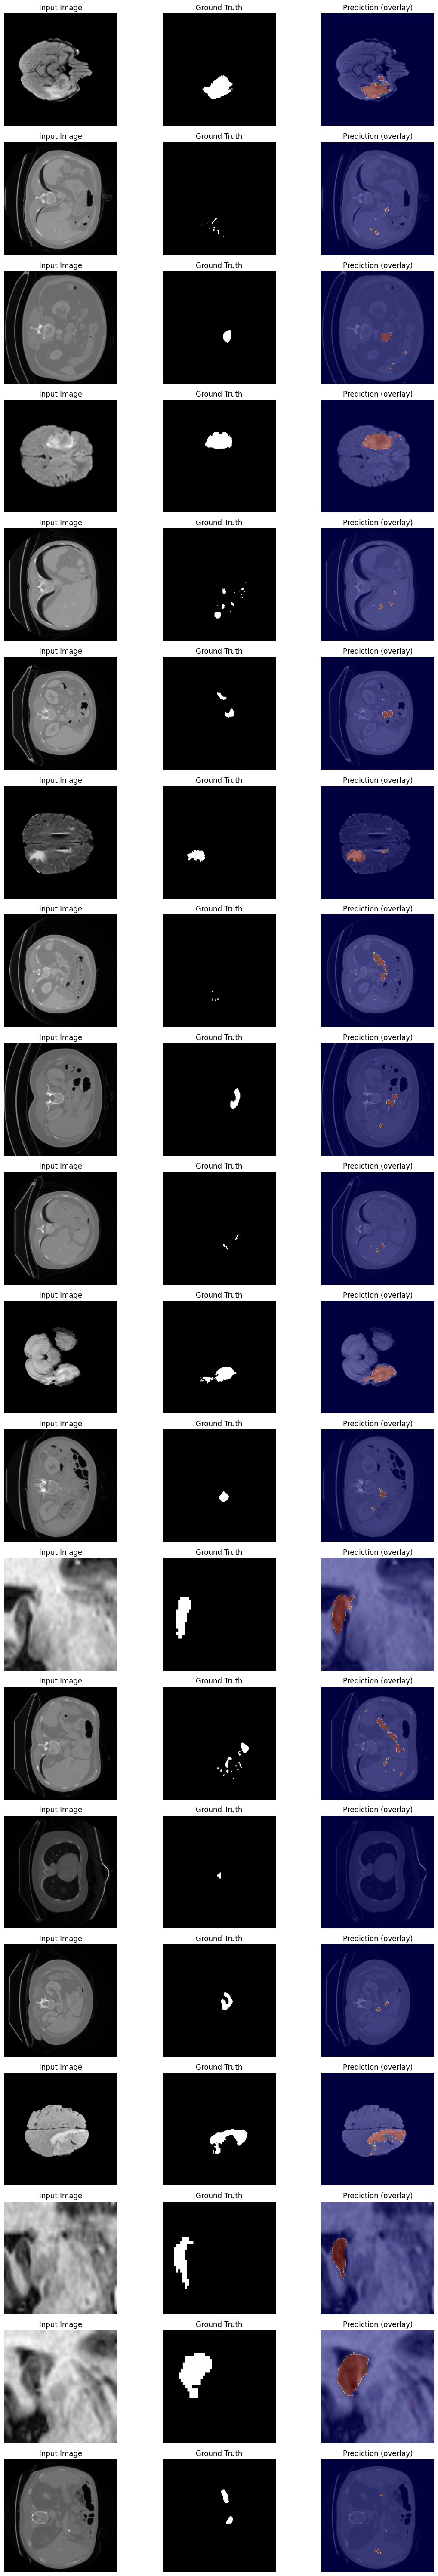

In [17]:
# ==========================================
# 🎨 Segmentation Visualization (Trained Student)
# ==========================================
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load the best checkpoint if needed
CKPT_PATH = "/kaggle/working/best_student.pt"
if Path(CKPT_PATH).exists():
    ckpt = torch.load(CKPT_PATH, map_location=device)
    student_model.load_state_dict(ckpt["student"])
    print(f"✅ Loaded best student model from {CKPT_PATH} (epoch {ckpt.get('epoch', '?')})")
else:
    print("⚠️ No checkpoint found, using current weights")

student_model.eval()

# ------------------------------
# Visualization Function
# ------------------------------
def visualize_predictions(model, dataset, num_samples=5, figsize=None):
    """
    Shows image, ground truth mask, and model prediction side by side.
    """
    if figsize is None:
        figsize = (12, num_samples * 3)

    plt.figure(figsize=figsize)
    idxs = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        if isinstance(sample, dict):
            img = sample["image"]
            mask = sample["mask"]
        else:
            img, mask = sample

        # Ensure tensors
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(np.copy(img)).permute(2,0,1)
        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(np.copy(mask))

        img_t = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = torch.sigmoid(model(img_t))[0].cpu().numpy()

        # Convert to displayable format
        img_np = img.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.squeeze().cpu().numpy()
        pred_np = pred.squeeze()

        # Normalize image
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

        # Create 3 panels
        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(img_np, cmap="gray")
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(img_np, cmap="gray")
        plt.imshow(pred_np > 0.5, cmap="jet", alpha=0.5)
        plt.title("Prediction (overlay)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage — visualize on validation set
visualize_predictions(student_model, val_ds, num_samples=20)


In [20]:
# KD Cell 1 — load frozen compatible MedSAM2 teacher + best student

import os, torch, torch.nn as nn
import torch.nn.functional as F

# Reuse your compatible teacher from Cell 8 (paste here if not in scope)
class MedSAM2CompatibleTeacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
            nn.Conv2d(64, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64,128,3, stride=2, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128,256,3, stride=2, padding=1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256,512,3, stride=2, padding=1, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
        )
        self.mask_decoder = nn.Sequential(
            nn.ConvTranspose2d(512,256,4,2,1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256,128,4,2,1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64,4,2,1), nn.BatchNorm2d(64),  nn.ReLU(inplace=True),
            nn.ConvTranspose2d( 64, 32,4,2,1), nn.BatchNorm2d(32),  nn.ReLU(inplace=True),
            nn.ConvTranspose2d( 32, 16,4,2,1), nn.BatchNorm2d(16),  nn.ReLU(inplace=True),
            nn.Conv2d(16,1,1),
        )
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)

    def forward(self, x):
        f = self.image_encoder(x)
        y = self.mask_decoder(f)
        if y.shape[-2:] != x.shape[-2:]:
            y = F.interpolate(y, size=x.shape[-2:], mode='bilinear', align_corners=False)
        return y

def load_teacher_from_ckpt(ckpt_path, model_ctor, device):
    assert os.path.exists(ckpt_path), f"Teacher ckpt not found: {ckpt_path}"
    model = model_ctor().to(device)
    raw = torch.load(ckpt_path, map_location="cpu")
    if isinstance(raw, dict):
        for k in ("state_dict","model","net","ema","teacher"):
            if k in raw and isinstance(raw[k], dict):
                raw = raw[k]; break
    sd = raw
    if any(k.startswith("module.") for k in sd.keys()):
        sd = {k.replace("module.", "", 1): v for k,v in sd.items()}
    own = model.state_dict()
    loadable = {k:v for k,v in sd.items() if k in own and own[k].shape==v.shape}
    model.load_state_dict(loadable, strict=False)
    model.eval()
    for p in model.parameters(): p.requires_grad = False
    print(f"✅ Teacher (compatible) loaded: matched={len(loadable)}/{len(own)}")
    return model

TEACHER_CKPT = r"/kaggle/input/medsam2-latest/pytorch/default/1/MedSAM2_latest.pt"   # set your path
teacher = load_teacher_from_ckpt(TEACHER_CKPT, MedSAM2CompatibleTeacher, device)

# Load your best student (prefer full model)
STUDENT_BEST_FULL = "/kaggle/working/best_student_full.pt"
STUDENT_BEST_STATE = "/kaggle/working/best_student_.pt"

try:
    student_model = torch.load(STUDENT_BEST_FULL, map_location="cpu").to(device)
    print("✅ Loaded best student (full model).")
except Exception as e:
    print("ℹ️ Full model load failed, using state_dict fallback:", e)
    # EfficientStudentModel must be defined (from your Cell 5)
    student_model = EfficientStudentModel().to(device)
    ck = torch.load(STUDENT_BEST_STATE, map_location="cpu")
    sd = ck.get("student", ck)
    student_model.load_state_dict(sd)
    print("✅ Loaded best student (state_dict).")

student_model.train()


✅ Teacher (compatible) loaded: matched=0/67
ℹ️ Full model load failed, using state_dict fallback: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.EfficientStudentModel was not an allowed global by default. Please use `torch.serialization.add_safe_globals([EfficientStudentModel])` or the `torch.serialization.safe_globals([EfficientStudentModel])` context manager to allowlist this global if you trust this class/

EfficientStudentModel(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
    (3): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU6(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0

In [18]:
# KD Cell 2 — minimal KD step (teacher probs at temperature) + quick eval

import torch.nn.functional as F
import torch

def kd_step_min(images, targets, tau=2.0, alpha=0.5):
    """
    logits_s ~ student_model(images)
    teacher is frozen; KD = 0.7*BCE(s, t_probs) + 0.3*Dice(s_probs, t_probs)
    final loss = alpha*KD + (1-alpha)*composite_supervised
    """
    s_logits = student_model(images)

    with torch.no_grad():
        t_logits = teacher(images)
        if t_logits.shape[-2:] != s_logits.shape[-2:]:
            t_logits = F.interpolate(t_logits, size=s_logits.shape[-2:], mode="bilinear", align_corners=False)
        t_probs = torch.sigmoid(t_logits / tau)

    kd_bce = F.binary_cross_entropy_with_logits(s_logits, t_probs)

    s_probs = torch.sigmoid(s_logits / tau)
    inter = (s_probs * t_probs).sum(dim=(1,2,3))
    union = s_probs.sum(dim=(1,2,3)) + t_probs.sum(dim=(1,2,3))
    kd_dice = 1.0 - ((2*inter + 1e-6) / (union + 1e-6)).mean()

    kd = 0.7*kd_bce + 0.3*kd_dice
    sup = composite_loss(s_logits, targets)          # uses your BCE+Dice+Focal+Boundary

    loss = alpha*kd + (1-alpha)*sup
    logs = {"loss": float(loss.detach()), "kd": float(kd.detach()), "sup": float(sup.detach())}
    return loss, logs

@torch.no_grad()
def kd_eval_quick(loader, thr=0.5, max_batches=4):
    student_model.eval()
    s, c = 0.0, 0
    for i, batch in enumerate(loader):
        if i >= max_batches: break
        imgs = batch["image"].to(device, non_blocking=True)
        msk  = batch["mask"].to(device, non_blocking=True)
        pr   = (torch.sigmoid(student_model(imgs)) > thr).float()
        inter = (pr*msk).sum(dim=(1,2,3))
        union = (pr+msk - pr*msk).sum(dim=(1,2,3)).clamp_min(1e-6)
        s += (inter/union).mean().item(); c += 1
    if c: print(f"🔎 KD QuickEval IoU@{thr}: {s/c:.4f}")
    student_model.train()


In [47]:
# ============================================================
# 🔥 Improved Knowledge Distillation Training
# ============================================================
import torch, torch.nn.functional as F
from torch.cuda.amp import autocast
import numpy as np

# Save clean pre-KD weights before starting
torch.save(student_model.state_dict(), "/kaggle/working/student_preKD_weights.pt")
print("💾 Saved clean pre-KD student weights.")

# Teacher setup (frozen)
teacher.eval()
for p in teacher.parameters(): 
    p.requires_grad_(False)

# KD configuration
kd_epochs = 5
alpha = 0.7        # KD vs supervised balance (↑ for stronger teacher guidance)
tau = 2.5          # Temperature smoothing
lr = 1e-4

optimizer = torch.optim.AdamW(student_model.parameters(), lr=lr, weight_decay=1e-5)
best_loss = float("inf")

print(f"\n🚀 Starting KD fine-tuning: {kd_epochs} epochs | α={alpha} | τ={tau}")
print("────────────────────────────────────────────")

for ep in range(1, kd_epochs + 1):
    student_model.train()
    total_loss, total_kd, total_sup = 0, 0, 0

    for step, batch in enumerate(train_loader):
        imgs = batch["image"].to(device, non_blocking=True)
        msk  = batch["mask"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=use_mixed_precision):
            s_out = student_model(imgs)
            with torch.no_grad():
                t_out = torch.sigmoid(teacher(imgs))  # teacher predictions

            # --- Supervised losses ---
            bce_loss = F.binary_cross_entropy_with_logits(s_out, msk)
            dice_loss = 1 - ((2 * (torch.sigmoid(s_out) * msk).sum() + 1e-6) /
                             (torch.sigmoid(s_out).sum() + msk.sum() + 1e-6))
            sup_loss = bce_loss + 0.3 * dice_loss

            # --- KD loss ---
            kd_loss = F.mse_loss(torch.sigmoid(s_out / tau),
                                 torch.sigmoid(t_out / tau))

            # --- Combined ---
            loss = alpha * kd_loss + (1 - alpha) * sup_loss

        if use_mixed_precision and scaler is not None:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1.0)
            optimizer.step()

        total_loss += loss.item()
        total_kd   += kd_loss.item()
        total_sup  += sup_loss.item()

        # Print progress every ~200 steps
        if (step + 1) % 200 == 0:
            print(f"[E{ep:02d} {step+1:05d}/{len(train_loader)}] "
                  f"loss={total_loss/(step+1):.4f}  KD={total_kd/(step+1):.4f}  SUP={total_sup/(step+1):.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {ep}/{kd_epochs} done — avg_loss={avg_loss:.4f}\n")

    # Save best checkpoint
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(student_model.state_dict(), "/kaggle/working/student_postKD_weights.pt")
        print("💾 Saved improved post-KD weights.\n")

print("🎯 KD fine-tuning complete!")


💾 Saved clean pre-KD student weights.

🚀 Starting KD fine-tuning: 5 epochs | α=0.7 | τ=2.5
────────────────────────────────────────────


/tmp/ipykernel_37/1452676523.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_mixed_precision):


[E01 00200/12213] loss=0.1599  KD=0.0655  SUP=0.3801
[E01 00400/12213] loss=0.1554  KD=0.0749  SUP=0.3433
[E01 00600/12213] loss=0.1534  KD=0.0789  SUP=0.3275
[E01 00800/12213] loss=0.1524  KD=0.0809  SUP=0.3194
[E01 01000/12213] loss=0.1518  KD=0.0823  SUP=0.3138
[E01 01200/12213] loss=0.1515  KD=0.0830  SUP=0.3113
[E01 01400/12213] loss=0.1510  KD=0.0837  SUP=0.3081
[E01 01600/12213] loss=0.1508  KD=0.0841  SUP=0.3063
[E01 01800/12213] loss=0.1504  KD=0.0845  SUP=0.3043
[E01 02000/12213] loss=0.1501  KD=0.0849  SUP=0.3021
[E01 02200/12213] loss=0.1499  KD=0.0852  SUP=0.3007
[E01 02400/12213] loss=0.1498  KD=0.0854  SUP=0.3000
[E01 02600/12213] loss=0.1497  KD=0.0857  SUP=0.2990
[E01 02800/12213] loss=0.1496  KD=0.0859  SUP=0.2981
[E01 03000/12213] loss=0.1495  KD=0.0861  SUP=0.2973
[E01 03200/12213] loss=0.1493  KD=0.0862  SUP=0.2965
[E01 03400/12213] loss=0.1492  KD=0.0863  SUP=0.2960
[E01 03600/12213] loss=0.1492  KD=0.0864  SUP=0.2957
[E01 03800/12213] loss=0.1491  KD=0.0864  SUP=

In [28]:
save_path = "/kaggle/working/best_student_kd_wtsonly.pt"
torch.save(student_model.state_dict(), save_path)


In [30]:
CKPT_PATH = "/kaggle/working/best_student_kd_full.pt"

if Path(CKPT_PATH).exists():
    ckpt = torch.load(CKPT_PATH, map_location=device)

    # handle all 3 possible save styles automatically
    if isinstance(ckpt, dict):
        if "student" in ckpt:
            student_model.load_state_dict(ckpt["student"])
            print(f"✅ Loaded weights from dict (epoch {ckpt.get('epoch', '?')})")
        else:
            student_model.load_state_dict(ckpt)
            print("✅ Loaded weights from plain state_dict")
    else:
        # if the full model object was saved
        student_model = ckpt
        print("✅ Loaded full model object")
else:
    print("⚠️ No checkpoint found — using current model weights")

student_model.eval()


✅ Loaded weights from plain state_dict


EfficientStudentModel(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
    (3): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU6(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0

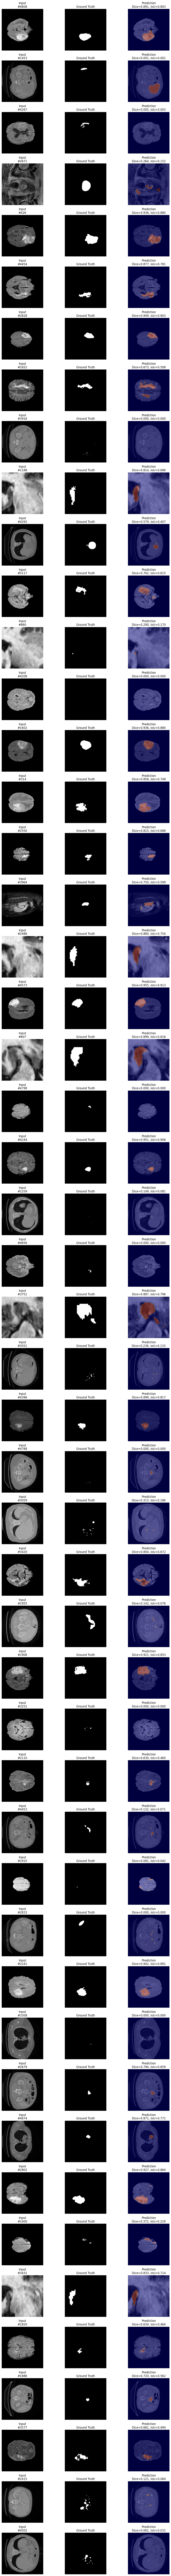

In [52]:
# ==========================================
# 🎨 Segmentation Visualization + Dice & IoU
# ==========================================
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ---- Metric helpers ----
def dice_coeff(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    inter = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2 * inter + eps) / (union + eps)

def iou_coeff(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    inter = (pred * target).sum()
    union = pred.sum() + target.sum() - inter
    return (inter + eps) / (union + eps)

# ---- Visualization function ----
def visualize_predictions_with_metrics(model, dataset, num_samples=6, figsize=None):
    model.eval()
    if figsize is None:
        figsize = (12, num_samples * 3)

    idxs = np.random.choice(len(dataset), num_samples, replace=False)
    plt.figure(figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        img = sample["image"].to(device)
        mask = sample["mask"].to(device)

        with torch.no_grad():
            pred = torch.sigmoid(model(img.unsqueeze(0)))[0]

        dice = dice_coeff(pred, mask).item()
        iou = iou_coeff(pred, mask).item()

        img_np = img.permute(1,2,0).cpu().numpy()
        mask_np = mask.squeeze().cpu().numpy()
        pred_np = pred.squeeze().cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(img_np, cmap="gray")
        plt.title(f"Input\n#{idx}")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(img_np, cmap="gray")
        plt.imshow(pred_np > 0.5, cmap="jet", alpha=0.5)
        plt.title(f"Prediction\nDice={dice:.3f}, IoU={iou:.3f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---- Run visualization ----
visualize_predictions_with_metrics(student_model, val_ds, num_samples=50)


🧠 Found 2008 brain images in validation set.


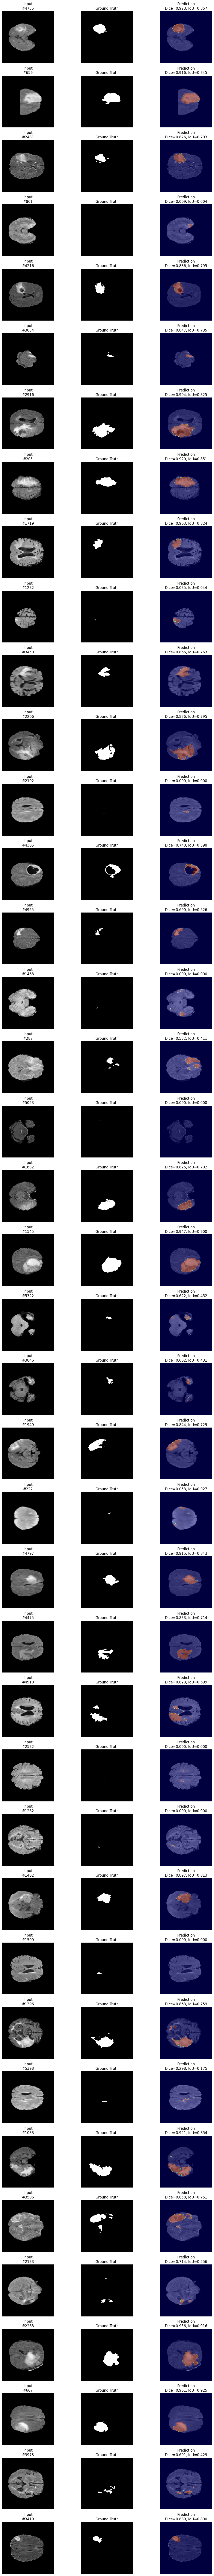

In [54]:
# ==========================================
# 🧠 Brain-only Visualization with Dice & IoU
# ==========================================
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

# ---- Metric helpers ----
def dice_coeff(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    inter = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2 * inter + eps) / (union + eps)

def iou_coeff(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    inter = (pred * target).sum()
    union = pred.sum() + target.sum() - inter
    return (inter + eps) / (union + eps)

# ---- Brain filter ----
brain_indices = [i for i in range(len(val_ds)) 
                 if "brain" in str(val_ds.df.iloc[i].get("image_path", "")).lower() 
                 or "Task01_Brain" in str(val_ds.df.iloc[i].get("image_path", ""))]

print(f"🧠 Found {len(brain_indices)} brain images in validation set.")

# ---- Visualization function ----
def visualize_brain_predictions(model, dataset, brain_indices, num_samples=6, figsize=None):
    model.eval()
    if len(brain_indices) == 0:
        print("⚠️ No brain images found — check your organ labels or filenames.")
        return
    
    if figsize is None:
        figsize = (12, num_samples * 3)
    
    chosen_idxs = random.sample(brain_indices, min(num_samples, len(brain_indices)))
    plt.figure(figsize=figsize)

    for i, idx in enumerate(chosen_idxs):
        sample = dataset[idx]
        img = sample["image"].to(device)
        mask = sample["mask"].to(device)

        with torch.no_grad():
            pred = torch.sigmoid(model(img.unsqueeze(0)))[0]

        dice = dice_coeff(pred, mask).item()
        iou = iou_coeff(pred, mask).item()

        img_np = img.permute(1,2,0).cpu().numpy()
        mask_np = mask.squeeze().cpu().numpy()
        pred_np = pred.squeeze().cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(img_np, cmap="gray")
        plt.title(f"Input\n#{idx}")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(img_np, cmap="gray")
        plt.imshow(pred_np > 0.5, cmap="jet", alpha=0.5)
        plt.title(f"Prediction\nDice={dice:.3f}, IoU={iou:.3f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# ---- Run visualization ----
visualize_brain_predictions(student_model, val_ds, brain_indices, num_samples=40)
